# 0. Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import SBDataset
from torchvision import transforms

In [3]:
np.random.seed(2510)
torch.manual_seed(2510)
torch.cuda.manual_seed(2510)

# 1. Dataset

In [4]:
to_tensor = transforms.ToTensor()  # for images

class SBBinaryDataset(Dataset):
    def __init__(self, root="./data", image_set="train", img_size=None, download=False):
        self.ds = SBDataset(root=root, mode='segmentation', image_set=image_set, download=download)
        self.img_size = img_size  # (W,H) or None

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, mask = self.ds[idx]  # img: PIL RGB, mask: PIL L
        if self.img_size is not None:
            img = img.resize(self.img_size, Image.BILINEAR)
            mask = mask.resize(self.img_size, Image.NEAREST)

        img_t = to_tensor(img)  # C,H,W float in [0,1]

        mask_np = np.array(mask)  # H,W
        # valid_mask: 1 where not 255, else 0
        valid_mask = (mask_np != 255).astype(np.uint8)
        # binary foreground: 1 where class index != 0 AND not ignore
        # (treat any non-zero class as foreground)
        mask_bin = ((mask_np != 0) & (mask_np != 255)).astype(np.uint8)

        # convert to tensors shaped 1,H,W
        mask_t = torch.from_numpy(mask_bin).unsqueeze(0).float()
        valid_t = torch.from_numpy(valid_mask).unsqueeze(0).float()

        return img_t, mask_t, valid_t

In [6]:
try :
  sb_binary_train = SBBinaryDataset(root="./data", image_set="train", download=False)
  sb_binary_val = SBBinaryDataset(root="./data", image_set="val", download=False)
except RuntimeError :
  sb_binary_train = SBBinaryDataset(root="./data", image_set="train", download=True)
  sb_binary_val = SBBinaryDataset(root="./data", image_set="val", download=True)

In [7]:
sb_binary_train[5]

(tensor([[[0.2314, 0.3608, 0.4196,  ..., 0.3882, 0.3686, 0.3804],
          [0.2627, 0.3765, 0.4275,  ..., 0.4078, 0.4078, 0.4118],
          [0.3137, 0.3961, 0.4510,  ..., 0.3922, 0.4000, 0.3961],
          ...,
          [0.4784, 0.4588, 0.4980,  ..., 0.9922, 1.0000, 0.9843],
          [0.4667, 0.4667, 0.4980,  ..., 0.9922, 0.9843, 0.8235],
          [0.4588, 0.4824, 0.4980,  ..., 0.9255, 0.7882, 0.6784]],
 
         [[0.0824, 0.1451, 0.1882,  ..., 0.2745, 0.2588, 0.2784],
          [0.0941, 0.1686, 0.2196,  ..., 0.2627, 0.2627, 0.2784],
          [0.1216, 0.1765, 0.2078,  ..., 0.2667, 0.2745, 0.2706],
          ...,
          [0.3961, 0.4039, 0.3882,  ..., 0.9922, 1.0000, 0.9922],
          [0.4000, 0.4039, 0.3961,  ..., 1.0000, 0.9961, 0.8314],
          [0.4039, 0.4039, 0.4000,  ..., 0.9294, 0.7882, 0.6902]],
 
         [[0.0392, 0.0275, 0.0627,  ..., 0.2196, 0.2039, 0.2196],
          [0.0196, 0.0471, 0.0235,  ..., 0.2314, 0.2314, 0.2392],
          [0.0000, 0.0392, 0.0157,  ...,

## 1.1 Example Display

In [8]:
x, y, z = sb_binary_train[5]

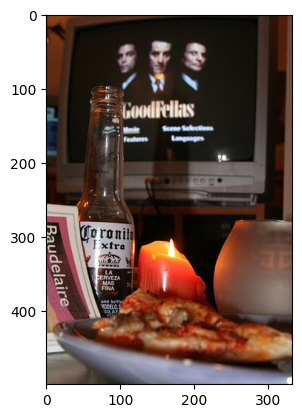

In [9]:
plt.imshow(x.numpy().transpose(1,2,0))

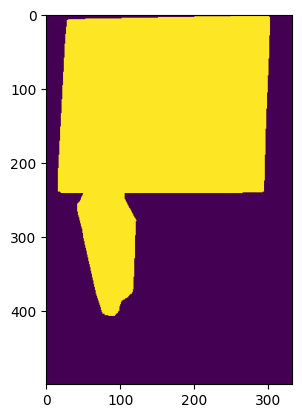

In [10]:
plt.imshow(y.numpy()[0])

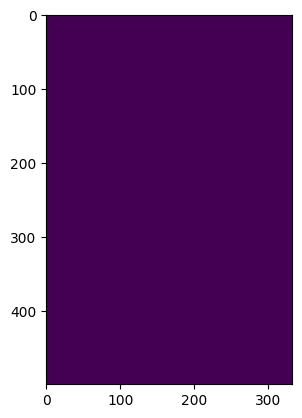

In [11]:
plt.imshow(z.numpy()[0])

# 2. Dataloader

In [12]:
def pad_to_shape(tensor, target_h, target_w, pad_value=0):
    # tensor shape: C,H,W or 1,H,W
    c, h, w = tensor.shape
    if h == target_h and w == target_w:
        return tensor
    pad_h = target_h - h
    pad_w = target_w - w
    # padding format for F.pad is (pad_w_left, pad_w_right, pad_h_top, pad_h_bottom)
    # here we pad only on the bottom/right for simplicity
    pad = (0, pad_w, 0, pad_h)
    return F.pad(tensor, pad, value=pad_value)

def pad_collate(batch):
    """
    batch: list of tuples (img_t, mask_t, valid_t)
      img_t: tensor C x H x W (float)
      mask_t: tensor 1 x H x W (0/1 float)
      valid_t: tensor 1 x H x W (0/1 float)
    returns: stacked tensors BxCxtargetHxW, Bx1xHxxW, Bx1xHxxW
    """
    # find max height and width in this batch
    max_h = 0
    max_w = 0
    for img, mask, valid in batch:
        _, h, w = img.shape
        if h > max_h: max_h = h
        if w > max_w: max_w = w

    imgs_p = []
    masks_p = []
    valids_p = []
    for img, mask, valid in batch:
        img_p = pad_to_shape(img, max_h, max_w, pad_value=0.0)       # black pad
        mask_p = pad_to_shape(mask, max_h, max_w, pad_value=0.0)     # pad mask as background
        valid_p = pad_to_shape(valid, max_h, max_w, pad_value=0.0)   # padded valid=0 so loss ignores
        imgs_p.append(img_p)
        masks_p.append(mask_p)
        valids_p.append(valid_p)

    imgs_batch = torch.stack(imgs_p, dim=0)
    masks_batch = torch.stack(masks_p, dim=0)
    valids_batch = torch.stack(valids_p, dim=0)
    return imgs_batch, masks_batch, valids_batch

In [13]:
train_loader = DataLoader(sb_binary_train, batch_size=64, shuffle=True, num_workers=2, drop_last=True, collate_fn=pad_collate)
val_loader = DataLoader(sb_binary_val, batch_size=32, shuffle=False, num_workers=2, drop_last=True, collate_fn=pad_collate)

# 3. Model

## 3.1 Segmentation Loss

In [14]:
def masked_bce_with_logits(logits, targets, valid_mask):
    """
    logits: Bx1xHxW
    targets: Bx1xHxW (0/1)
    valid_mask: Bx1xHxW (1 = valid, 0 = ignore)
    """
    # per-pixel BCE (no reduction)
    loss_per_pixel = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    # mask out ignored pixels
    masked = loss_per_pixel * valid_mask
    # average over valid pixels
    denom = valid_mask.sum()
    return masked.sum() / (denom + 1e-6)

In [15]:
def masked_dice_loss(logits, targets, valid_mask, eps=1e-6):
    probs = torch.sigmoid(logits)
    # flatten per sample
    probs = probs * valid_mask
    targets = targets * valid_mask
    inter = (probs * targets).sum(dim=(1,2,3))
    denom = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2 * inter + eps) / (denom + eps)
    return (1 - dice).mean()

## 3.2 Model Initialization

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

def make_binary_deeplab(weights = None):
    model = deeplabv3_resnet50(weights = weights)
    # replace final conv to output 1 channel (original deeplabv3 outputs 21 channel, here we're only differentiating foreground from background)
    model.classifier[-1] = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1)
    model.aux_classifier = None
    return model

In [17]:
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = make_binary_deeplab(weights = DeepLabV3_ResNet50_Weights.DEFAULT)
model.to(device)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:00<00:00, 186MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# 4. Training Process

## 4.1 Train/Test Functions

In [18]:
def train(dataloader, model, optim):
    size = len(dataloader.dataset)
    total_loss = 0

    model.train()
    for batch, (img, mask, valids) in enumerate(dataloader):
        optim.zero_grad()

        img, mask, valids = img.to(device), mask.to(device), valids.to(device)
        logits = model(img)['out']

        loss = masked_bce_with_logits(logits, mask, valids) + masked_dice_loss(logits, mask, valids)
        loss.backward()
        optim.step()

        total_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(img)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return total_loss / len(dataloader)

In [19]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for batch, (img, mask, valids) in enumerate(dataloader):
            img, mask, valids = img.to(device), mask.to(device), valids.to(device)
            logits = model(img)['out']

            loss = masked_bce_with_logits(logits, mask, valids) + masked_dice_loss(logits, mask, valids)

            total_loss += loss.item()

    print(f"Test loss: {total_loss / len(dataloader):>7f}")
    return total_loss / len(dataloader)

## 4.2 Classifier head catchup

In [20]:
# Freeze backbone
for p in model.backbone.parameters():
    p.requires_grad = False

# If classifier has extra modules (ASPP, etc.), make sure they are trainable
for name, p in model.classifier.named_parameters():
    p.requires_grad = True

In [21]:
head_params = [p for n,p in model.classifier.named_parameters() if p.requires_grad]
opt = torch.optim.AdamW([{'params': head_params, 'lr': 1e-3}], weight_decay=1e-4)

In [ ]:
train_loss_arr = []
test_loss_arr = []

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_arr.append(train(train_loader, model, opt))
    test_loss = test(val_loader, model)

    if (len(test_loss_arr) > 1) and (test_loss < min(test_loss_arr)):
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved model state from epoch {t + 1}")

    test_loss_arr.append(test_loss)

print("Done!")

Epoch 1
-------------------------------
loss: 1.320556  [   64/ 8498]
loss: 0.336207  [ 6464/ 8498]


In [ ]:
fig = plt.Figure()
plt.plot(train_loss_arr, label="Train Loss", color="blue")
plt.plot(test_loss_arr, label="Test Loss", color="green")
plt.legend()
plt.show()

## 4.3 Full model training

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
# Unfreeze backbone
for p in model.backbone.parameters():
    p.requires_grad = True

# Often you want a smaller LR for pretrained backbone, and a larger LR for the classifier
backbone_params = [p for n,p in model.backbone.named_parameters() if p.requires_grad]
classifier_params = [p for n,p in model.classifier.named_parameters() if p.requires_grad]

opt = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},      # small LR
    {'params': classifier_params, 'lr': 1e-4}     # larger LR for head
], weight_decay=1e-4)


In [ ]:
train_loss_arr = []
test_loss_arr = []

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_arr.append(train(train_loader, model, opt))
    test_loss = test(train_loader, model)

    if (len(test_loss_arr) > 1) and (test_loss < min(test_loss_arr)):
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved model state from epoch {t + 1}")

    test_loss_arr.append(test_loss)

print("Done!")

In [ ]:
fig = plt.Figure()
plt.plot(train_loss_arr, label="Train Loss", color="blue")
plt.plot(test_loss_arr, label="Test Loss", color="green")
plt.legend()
plt.show()